<a href="https://colab.research.google.com/github/nautiism/i2b2AL/blob/master/KeepAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#for  uploading the dataset on colab
from gensim.models import KeyedVectors
filename = 'drive/My Drive'+'/'+'wikipedia-pubmed-and-PMC-w2v.bin'
pubmed = KeyedVectors.load_word2vec_format(filename, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import torch.nn.init as init
from torch.distributions import Categorical

print(torch.__version__)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import euclidean_distances
from pyemd import emd
import itertools
import nltk
nltk.download('stopwords')

import warnings; warnings.simplefilter('ignore')


1.1.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def weight_init(m):
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

In [0]:
class ActorCritic(nn.Module):
    def __init__(self, hidden_size=150, embedding_length=200): 
      super(ActorCritic, self).__init__()
      
      #actor
      self.bilstm = nn.LSTM(embedding_length, hidden_size, num_layers=2 , batch_first = True, bidirectional=True)
      self.s1 = nn.Linear(2*hidden_size, 150)
      self.s2 = nn.Linear(150, 30)
      self.fc_layer_1 = nn.Linear(30*2*hidden_size, 1000)
      self.fc_layer_2 = nn.Linear(1000, 250)
      self.a_compress = nn.Linear(250, 4)
      self.c_compress = nn.Linear(250, 1)
      
      self.logsoft = nn.LogSoftmax(dim=-1)
      self.apply(weight_init)
      
    def attention_net(self, lstm_output,s1,s2):
      attn_weight_matrix = s2(torch.tanh(s1(lstm_output)))
      attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
      attn_weight_matrix = F.softmax(attn_weight_matrix, dim=2)
      return attn_weight_matrix
        
    def init(self,h_0,c_0):
        self.h_0 = h_0
        self.c_0 = c_0
    
    def forward(self,inp):
      output, (h_n, c_n) = self.bilstm(inp, (self.h_0, self.c_0))
      attn_weight = self.attention_net(output,self.s1,self.s2)
      hidden_matrix = torch.bmm(attn_weight, output)
      fc_out = self.fc_layer_1(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2]))
      fc_out = self.fc_layer_2(fc_out)
      
      a_comp = self.a_compress(fc_out)
      sf = self.logsoft(a_comp)
      distribution = Categorical(sf)
      
      value = self.c_compress(fc_out)
      return distribution,value
      
def calculateLoss(rew,logprobs,state_values,gamma=0.99):
  rewards = []
  dis_reward = 0
  for reward in rew[::-1]:
      dis_reward = reward + gamma * dis_reward
      rewards.insert(0, dis_reward)

  rewards = torch.tensor(rewards)
  rewards = (rewards - rewards.mean()) / (rewards.std())
  rewards = [torch.tensor([reward],requires_grad = True).cuda() for reward in rewards]
  logprobs = [torch.tensor([lp],requires_grad = True).cuda() for lp in logprobs]
  state_values = [torch.tensor([val],requires_grad = True).cuda() for val in state_values]
  
  loss = 0
  for logprob, value, reward in zip(logprobs, state_values, rewards):
      advantage = reward  - value
      action_loss = -1*logprob * advantage
      value_loss = F.smooth_l1_loss(value, reward)
      loss += (action_loss + value_loss)
  return loss     

In [0]:
stop_words = set(stopwords.words('english')) 

import os
name = os.listdir('drive/My Drive/Colab Notebooks/test_data/')
tlist = [n.split('.')[0] for n in name if '.txt' in n]

tpath = 'drive/My Drive/Colab Notebooks/test_data/'
allre = {}
for fname in tlist:
    f=open(tpath+fname+'.txt')
    rec = []
    for l in f:
        for w in l.split():
          rec.append(w.lower())
    allre[fname] = rec

for rk in allre.keys():
    for i,word in enumerate(allre[rk]):
      allre[rk][i] = ''.join(e for e in word if e.isalpha())
      
for rk in allre.keys():
  line = []
  for word in allre[rk]:
    if word not in stop_words and not word.isdigit() and len(word) >= 3:
      line.append(word)
  allre[rk] = line
  
tmp = {}
for rk in allre.keys():
    tmp1 = []
    for i,word in enumerate(allre[rk]):
      if word in pubmed:
        tmp1.append(allre[rk][i])
    tmp[rk] = tmp1
        
sent = tmp

In [132]:
import pickle
file = open('./drive/My Drive/Colab Notebooks/seedstate.pkl', 'rb')
moolstate = pickle.load(file)
file.close()
moolstate.shape

torch.Size([2, 2, 1, 150])

In [0]:
#Environment
import pickle

class Env(object):
  def __init__(self,sent):
    self.sent = sent
    self.CBoD = []
    self.exit = False
    self.loadWMDMatrix()
    
  def pullList(k):
    file = open('./drive/My Drive/Colab Notebooks/wmdm/wmdm_'+k+'.pkl', 'rb')
    tmp = pickle.load(file)
    file.close()
    return tmp
    
  def loadWMDMatrix(self):
    li = [item.split('_')[1].split('.')[0] for item in os.listdir('./drive/My Drive/Colab Notebooks/wmdm/') if 'wmdm_' in item]
    self.wmdm = {}
    
    for k1 in li:
      self.wmdm[k1] = pullList(k1)
    
    for k1 in li:
      for k2 in li:
        if k1 == k2:
          continue
        if k2 not in self.wmdm[k1].keys():
          self.wmdm[k1][k2] = self.wmdm[k2][k1]
        if k1 not in self.wmdm[k2].keys():
          self.wmdm[k2][k1] = self.wmdm[k1][k2]
    print('Rewards loaded')
        
  def wmd(self,d1,d2):    
   
    vect = CountVectorizer(stop_words="english").fit([d1, d2])
    v_1, v_2 = vect.transform([d1, d2])
    v_1 = v_1.toarray().ravel().astype(np.double)
    v_2 = v_2.toarray().ravel().astype(np.double)
    v_1 /= v_1.sum()
    v_2 /= v_2.sum()
    W_ = []
    
    for w in vect.get_feature_names():
      W_.append(pubmed.word_vec(w))
     
        
    D_ = euclidean_distances(W_).astype(np.double)
    D_ /= D_.max()
    return emd(v_1, v_2, D_)
  
  def reward(self):
    combo = list(itertools.combinations(self.CBoD,2))
    sm = 0
    
    
    for d in combo:
      try:
        sm += self.wmdm[d[0]][d[1]]
      except KeyError:
        d1 = ' '.join(self.sent[d[0]])
        d2 = ' '.join(self.sent[d[1]])
        dist_ = self.wmd(d1,d2)
        if d[0] not in self.wmdm.keys():
          self.wmdm[d[0]] = {}
        if d[1] not in self.wmdm.keys():
          self.wmdm[d[1]] = {}
        self.wmdm[d[0]][d[1]] = dist_
        self.wmdm[d[1]][d[0]] = dist_
        sm += self.wmdm[d[0]][d[1]]
        print('added:'+d[0]+','+d[1])
        continue
      
      
    if len(combo)==0:
      combo = [1]
    
    norm_sm = sm/len(combo)
    penalty = np.exp(1- 1/len(combo))
    if len(combo)==0:
      penalty*=20
    reward = norm_sm - penalty
    return reward
  
  def makeStateTensor(self):
    if len(self.CBoD)==0:
      return []
    flat_list = []
    tmp = [w for k in self.CBoD for w in self.sent[k]]
    for w in tmp:
        flat_list.append(torch.from_numpy(pubmed.word_vec(w)))
    flat_list = torch.stack(flat_list).view(len(flat_list),1,-1)
    return flat_list.view(1,-1,200).cuda()
   
  def step(self,a):
    
    #act on the action selected by the agent
    if a==0: #discard the last sentence 
      self.CBoD = self.CBoD[:-1]
      if len(self.CBoD) == 0:
        a=1  
    if a==1: #add new sentence
      while True:
        rkey = np.random.choice(list(self.sent.keys()))
        if rkey in self.CBoD:
          continue
        else:
          self.CBoD.append(rkey)
          break
    if a==2: #end the episode
      self.exit = True
        
    return (self.makeStateTensor(),self.reward(),self.exit)
  
  def reset(self):
    global moolstate
    self.CBoD = []
    self.exit = False
    h_0 = torch.stack([ moolstate[0].cuda() , moolstate[0].cuda() ]).view(4,1,150)
    c_0 = torch.stack([ moolstate[1].cuda() , moolstate[1].cuda() ]).view(4,1,150) 
    rkey = np.random.choice(list(self.sent.keys()))
    self.CBoD.append(rkey)
    return self.makeStateTensor(),h_0,c_0

In [0]:
import os

def lastMPath():
  path = './drive/My Drive/Colab Notebooks/models/'
  mods = [f for f in os.listdir(path) if 'model_' in f]
  if len(mods) != 0:
    return path,max([int(f.split('_')[1]) for f in mods]),True
  else:
    return '',0,False

def train(sent):
    render = False
    gamma = 0.99
    lr = 0.0001
    betas = (0.9, 0.999)
    random_seed = 543
    
    torch.manual_seed(random_seed)
    
    env = Env(sent)
    
    path,modNo,boole = lastMPath()
    ac = None
    if boole:
      print('Loaded:'+str(modNo))
      ac = torch.load(path+'model_'+str(modNo)).cuda()
    else:
      ac = ActorCritic().cuda()
      
    opt = optim.Adam(ac.parameters(), lr=lr)
    
    epi_reward = []
    epi_add_discard = []
    for i_episode in range(modNo+1, 150000):
        running_reward = 0
        discard = 0
        rewards = []
        log_probs = []
        values = []
        state,h_0,c_0 = env.reset()
        ac.init(h_0,c_0)
        for t in range(1000):
            action_dist,value = ac(state)
            action = action_dist.sample()
            if action==1:
              discard+=1
            log_probs.append(action_dist.log_prob(action))
            values.append(value)
            state, reward, exit = env.step(action)
            rewards.append(reward)
            running_reward += reward
            if exit:
                if i_episode % 100 == 0:
                  print('Episode:'+str(i_episode))
                  print('Saved:'+str(i_episode))
                  torch.save(ac, 'drive/My Drive/Colab Notebooks/models/model_'+str(i_episode)+'')
                  print('Episode Loss: '+str(running_reward))
                  print('Bo Documents: '+str(env.CBoD))
                  print('Discards: '+str(discard))
                break
        opt.zero_grad()
        loss = calculateLoss(rewards,log_probs,values,gamma)
        loss.backward()
        opt.step()
        epi_reward.append(running_reward)
        epi_add_discard.append(discard)
    return ac,epi_reward,epi_add_discard

ac,epi_reward,epi_add_discard = train(sent)

Rewards loaded
Episode:100
Saved:100
Episode Loss: -3.0
Bo Documents: ['0437']
Discards: 0
Episode:200
Saved:200
Episode Loss: -4.0
Bo Documents: ['0226']
Discards: 0
Episode:300
Saved:300
Episode Loss: -1.0
Bo Documents: ['0424']
Discards: 0
Episode:400
Saved:400
Episode Loss: -3.0
Bo Documents: ['0118']
Discards: 0
Episode:500
Saved:500
Episode Loss: -5.0
Bo Documents: ['0246']
Discards: 0
Episode:600
Saved:600
Episode Loss: -4.0
Bo Documents: ['0301']
Discards: 0
Episode:700
Saved:700
Episode Loss: -1.0
Bo Documents: ['0265']
Discards: 0
Episode:800
Saved:800
Episode Loss: -8.0
Bo Documents: ['0113']
Discards: 0
Episode:900
Saved:900
Episode Loss: -1.0
Bo Documents: ['0190']
Discards: 0
Episode:1000
Saved:1000
Episode Loss: -2.0
Bo Documents: ['0169']
Discards: 0
Episode:1100
Saved:1100
Episode Loss: -4.0
Bo Documents: ['0046']
Discards: 0
Episode:1200
Saved:1200
Episode Loss: -2.0
Bo Documents: ['0050']
Discards: 0
Episode:1300
Saved:1300
Episode Loss: -1.0
Bo Documents: ['0053']
D

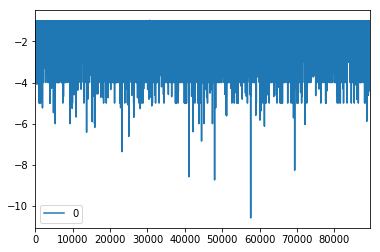

In [145]:
import pandas as pd
pd.DataFrame(epi_reward).plot.line()

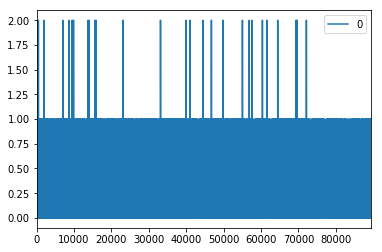

In [146]:
pd.DataFrame(epi_add_discard).plot.line()

In [0]:
import pickle
file = open('drive/My Drive/Colab Notebooks/test_dat.pkl', 'rb')
test_dat = pickle.load(file)
file.close()

In [148]:
def test(test_dat):
  env = Env(test_dat)
  combo = []
  for i_episode in range(0, 1):
      state,h_0,c_0 = env.reset()
      ac.init(h_0,c_0)
      for t in range(500):
          action_dist,value = ac(state)
          action = action_dist.sample()
          state, reward, exit = env.step(action)
          if exit:
             combo.append(env.CBoD)
  return list(set([item for sublist in combo for item in sublist]))
     
agent_set = test(test_dat)

Rewards loaded


AttributeError: ignored

In [0]:
file = open('./drive/My Drive/Colab Notebooks/agent_dat.pkl', 'wb')
pickle.dump(testing_dat,file)
file.close()